## 1 - Import Python Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import os


## 2 - Data Processing

Loadingraw data stored in the specified ``csv`` file and inspect the data format.

The task is to predicting stock's closing price of the next day given the prices from the previous.

Hence, the input is a sequence of closing prices of the stock, and the output is the closing price of the next day.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = 'AMZN_2006-01-01_to_2018-01-01.csv'
#data = pd.read_csv(os.path.join('data', filepath))
data = pd.read_csv("/content/drive/MyDrive/CISC684-Intro to ML/HW4/AMZN_2006-01-01_to_2018-01-01.csv")
data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


Plot the raw data.

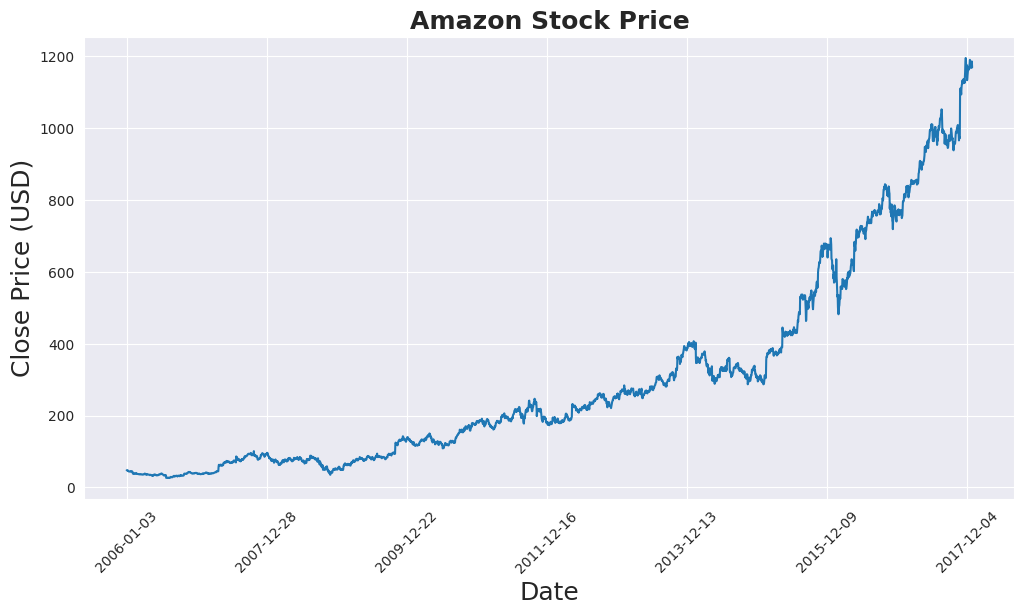

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize = (12,6))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()


Focus on the closing price, so the ``Close`` column in the data frame is extracted for the data.

In [ ]:
price = data[['Close']]
price.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019 entries, 0 to 3018
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3019 non-null   float64
dtypes: float64(1)
memory usage: 47.2 KB


Normalize the raw data into the range of ``[-1, 1]``.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


<ipython-input-6-33ec0e5dddec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


The following function helps process the raw data into the desired input and output formats, and at the same time splits the train and test data.

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]


Call the ``split_data`` function to retrieve ``x_train``, ``y_train``, ``x_test`` and ``y_test``.

In [ ]:
# process the raw data
lookback = 20 # choose sequence length

x_train, y_train, x_test, y_test = split_data(price, lookback)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


Convert from ``numpy.array`` to ``torch.tensor``.

In [ ]:
# Convert to torch Tensor
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

Hyper-parameters for later tunning if desired

In [ ]:
# hyper-parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1
num_epochs = 100
learning_rate = 0.01


In [ ]:
x_train = x_train.to(device, dtype=torch.float32)
x_test = x_test.to(device, dtype=torch.float32)
y_train = y_train.to(device, dtype=torch.float32)
y_test = y_test.to(device, dtype=torch.float32)

In [ ]:
x_train_LSTM_built_in = x_train.clone()
x_test_LSTM_built_in = x_test.clone()
y_train_LSTM_built_in = y_train.clone()
y_test_LSTM_built_in = y_test.clone()

In [ ]:
x_train_GRU_built_in = x_train.clone()
x_test_GRU_built_in = x_test.clone()
y_train_GRU_built_in = y_train.clone()
y_test_GRU_built_in = y_test.clone()

In [ ]:
print(x_train.dtype)

torch.float32


## 3 - Define the Model

Implementing an LSTM cell using only PyTorch's ``torch.nn.Linear`` layer and activation functions.

Below is the formula of now to calculate different gates, the hidden state and the cell state for timestep ``t`` given the hidden state and the cell state from ``t-1`` and the input from ``t``.


Input gate: $i_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})$

Forget gate: $f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})$

Cell gate: $g_t = \text{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})$

Output gate: $o_t = \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})$

Cell state: $c_t = f_t \odot c_{t-1} + i_t \odot g_t$

Hidden state: $h_t = o_t \odot \text{tanh}(c_t)$

where $\sigma$ denotes the sigmoid function and $\odot$ is the Hadamard product.

In [ ]:
class LSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, bias=True):
        super(LSTMCell, self).__init__()

        self.Wii = nn.Linear(input_dim, hidden_dim, bias = bias)
        self.Whi = nn.Linear(hidden_dim, hidden_dim, bias = bias)

        self.Wif = nn.Linear(input_dim, hidden_dim, bias = bias)
        self.Whf = nn.Linear(hidden_dim, hidden_dim, bias = bias)

        self.Wig = nn.Linear(input_dim, hidden_dim, bias = bias)
        self.Whg = nn.Linear(hidden_dim, hidden_dim, bias = bias)

        self.Wio = nn.Linear(input_dim, hidden_dim, bias = bias)
        self.Who = nn.Linear(hidden_dim, hidden_dim, bias = bias)

    def forward(self, x, h, c):

        it = torch.sigmoid(self.Wii*x + self.Whi*h)
        #it =

        ft = torch.sigmoid(self.Wif*x + self.Whf*h)
        #ft =

        gt = torch.tanh(self.Wig*x + self.Whg*h)
        #gt =

        ot = torch.sigmoid(self.Wio*x + self.Who*h)
        #ot =

        ct = ft * c + it * gt
        ht = ot * torch.tanh(ct)

        return ot, h, c


Now, implemented LSTM cell to implement a 1-layer LSTM network.

Note that we use the output embedding of the last timestep as the input to a linear layer that predicts the stock price.

Here, we can see the LSTM cell as the feature extractor, with the linear layer being the regressor.

Initialize the hidden and cell state at timestep 0.

In [ ]:
class LSTMNet(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, bias=True):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim

        self.lstm_cell = nn.LSTMCell(input_dim, hidden_dim, bias = bias)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        device = x.device
        # Define the initial hidden and cell states
        ht = torch.zeros(x.size(0), self.hidden_dim).to(device)
        ct = torch.zeros(x.size(0), self.hidden_dim).to(device)

        # Use a for-loop to define the forward pass of the LSTM network
        for i in range(x.size(1)):
          ht, ct = self.lstm_cell(x[:, i, :], (ht, ct))

        output = self.fc(ht)
        # Use the output embedding of the last timestep as the input to the linear layer


        return output


## 4 -  Training and Testing

Conduct the training and testing of the LSTM network on the stock prediction task.

First, define the model, loss function and optimizer.

Since it is a regression task, the standard loss function the Mean Squared Error is used.

For the optimizer, use the Adam.

In [ ]:
#send the model's weights to the appropriate device (GPU or CPU)
model = LSTMNet(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate )

model.to(device)


LSTMNet(
  (lstm_cell): LSTMCell(1, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.dtype)

lstm_cell.weight_ih torch.float32
lstm_cell.weight_hh torch.float32
lstm_cell.bias_ih torch.float32
lstm_cell.bias_hh torch.float32
fc.weight torch.float32
fc.bias torch.float32


Run the code below to conduct the training of the model.

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))


Epoch  0 MSE:  0.5988571643829346
Epoch  1 MSE:  0.3435693681240082
Epoch  2 MSE:  0.09424719959497452
Epoch  3 MSE:  0.3926323354244232
Epoch  4 MSE:  0.025675669312477112
Epoch  5 MSE:  0.06957042217254639
Epoch  6 MSE:  0.11425074189901352
Epoch  7 MSE:  0.13467229902744293
Epoch  8 MSE:  0.13755269348621368
Epoch  9 MSE:  0.12889713048934937
Epoch  10 MSE:  0.11287207901477814
Epoch  11 MSE:  0.09258080273866653
Epoch  12 MSE:  0.07075691968202591
Epoch  13 MSE:  0.05025160685181618
Epoch  14 MSE:  0.034291911870241165
Epoch  15 MSE:  0.02633233740925789
Epoch  16 MSE:  0.028925467282533646
Epoch  17 MSE:  0.039675816893577576
Epoch  18 MSE:  0.04865691438317299
Epoch  19 MSE:  0.04972836375236511
Epoch  20 MSE:  0.044312555342912674
Epoch  21 MSE:  0.036791715770959854
Epoch  22 MSE:  0.030500322580337524
Epoch  23 MSE:  0.026731187477707863
Epoch  24 MSE:  0.02537131868302822
Epoch  25 MSE:  0.025702061131596565
Epoch  26 MSE:  0.026895705610513687
Epoch  27 MSE:  0.0282481964677

Plot the training predictions along with the losses through time (epochs).

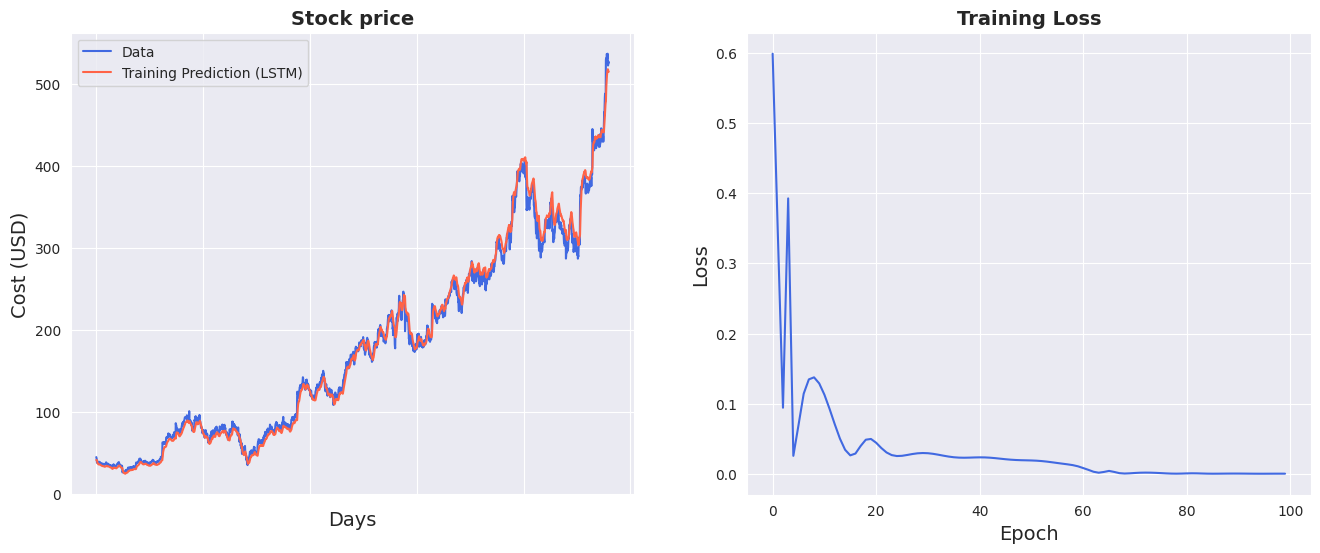

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().cpu().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().cpu().numpy()))

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


Make predictions on the testing set. Plot the training predictions through time (epochs).

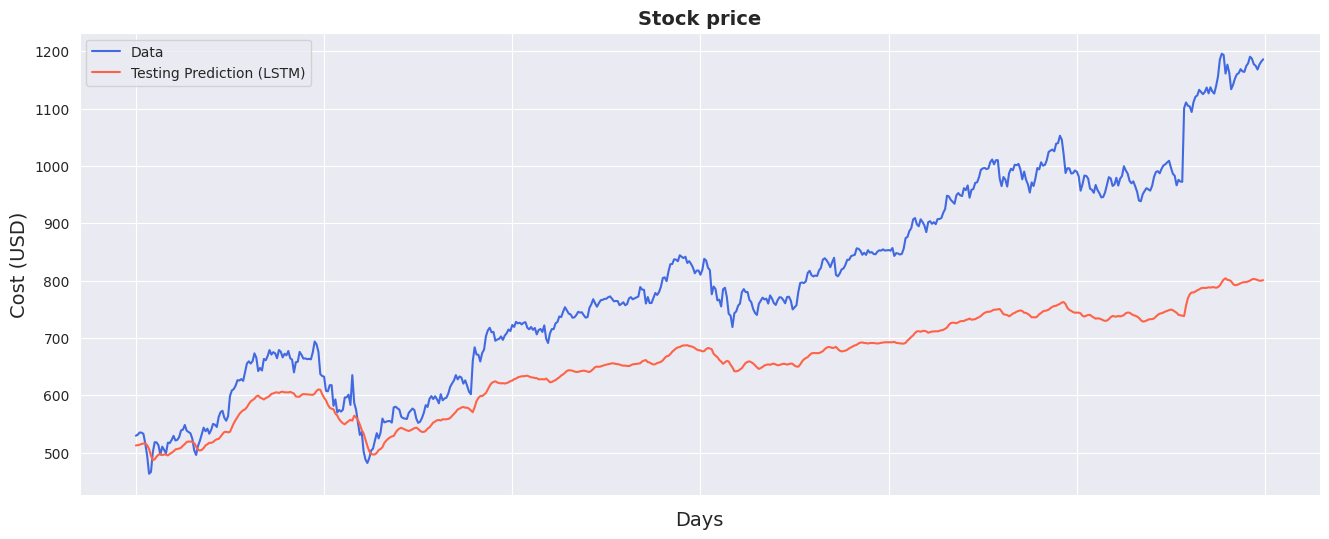

In [ ]:
# make predictions
with torch.no_grad():
    x_test = x_test.to(device)
    y_test_pred = model(x_test)

predict_test = pd.DataFrame(scaler.inverse_transform(y_test_pred.detach().cpu().numpy()))
original_test = pd.DataFrame(scaler.inverse_transform(y_test.detach().cpu().numpy()))

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test.index, y = original_test[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test.index, y = predict_test[0], label="Testing Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)


Calculate the MSE on both the training and testing data.

In [ ]:
# calculate root mean squared error
y_train = y_train.detach().cpu().numpy()
y_train_pred = y_train_pred.detach().cpu().numpy()
trainScore = np.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test = y_test.detach().cpu().numpy()
y_test_pred = y_test_pred.detach().cpu().numpy()
testScore = np.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.02 RMSE
Test Score: 0.29 RMSE


## 5 - Built-in LSTM

Training a 1-layer LSTM network using the PyTorch built-in LSTM cell.

In [ ]:
# Step 1: Define the LSTMNet class
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim

        # LSTM layer
        self.lstm_cell = nn.LSTMCell(input_dim, hidden_dim)

        # Linear layer for regression
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        device = x.device
        seq_length = x.size(1)

        # Initialize hidden state and cell state
        h_t = torch.zeros(x.size(0), self.hidden_dim).to(device)
        c_t = torch.zeros(x.size(0), self.hidden_dim).to(device)

        # Use a for-loop to define the forward pass of the LSTM network
        for t in range(seq_length):
            h_t, c_t = self.lstm_cell(x[:, t, :], (h_t, c_t))

        # Use the output embedding of the last timestep as the input to the linear layer
        output = self.fc(h_t)

        return output

In [ ]:
# Step 2: Create the model, loss function, and optimizer
input_dim = 1  # Input dimension (number of features in the input)
hidden_dim = 64  # Number of units in the hidden LSTM layer
output_dim = 1  # Output dimension (number of features in the output)
learning_rate = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMNet(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
# Step 3: Train the model and record training losses
num_epochs = 100
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train_LSTM_built_in.shape
    y_train_LSTM_built_in.shape
    x_train_LSTM_built_in = x_train_LSTM_built_in.to(device)
    y_train_LSTM_built_in = y_train_LSTM_built_in.to(device)

    y_train_pred_LSTM_built_in = model(x_train_LSTM_built_in)

    loss = criterion(y_train_pred_LSTM_built_in, y_train_LSTM_built_in)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4727720618247986
Epoch  1 MSE:  0.25839686393737793
Epoch  2 MSE:  0.07426023483276367
Epoch  3 MSE:  0.23628902435302734
Epoch  4 MSE:  0.023077545687556267
Epoch  5 MSE:  0.055375952273607254
Epoch  6 MSE:  0.08610305190086365
Epoch  7 MSE:  0.09741495549678802
Epoch  8 MSE:  0.09407415986061096
Epoch  9 MSE:  0.08157745748758316
Epoch  10 MSE:  0.06453904509544373
Epoch  11 MSE:  0.04704083502292633
Epoch  12 MSE:  0.03300122544169426
Epoch  13 MSE:  0.02605319581925869
Epoch  14 MSE:  0.02828284353017807
Epoch  15 MSE:  0.03657275065779686
Epoch  16 MSE:  0.042663805186748505
Epoch  17 MSE:  0.04239438474178314
Epoch  18 MSE:  0.03746068477630615
Epoch  19 MSE:  0.03151014819741249
Epoch  20 MSE:  0.02703881822526455
Epoch  21 MSE:  0.024801304563879967
Epoch  22 MSE:  0.024449216201901436
Epoch  23 MSE:  0.025217238813638687
Epoch  24 MSE:  0.02633289434015751
Epoch  25 MSE:  0.027206240221858025
Epoch  26 MSE:  0.027495266869664192
Epoch  27 MSE:  0.0271021984517

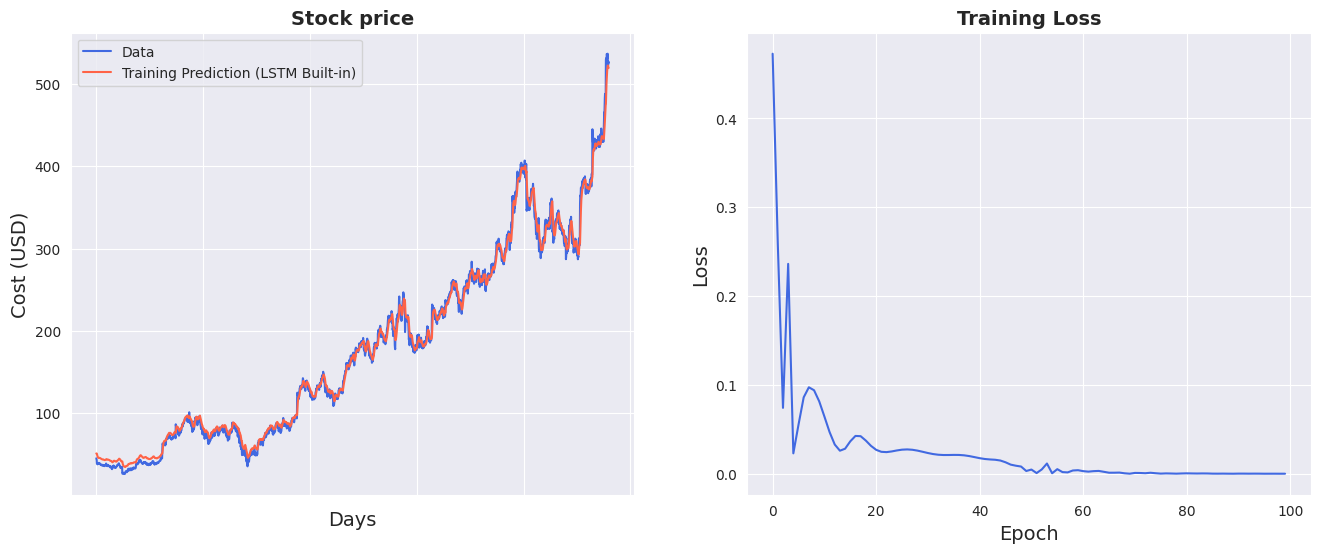

In [ ]:
predict_LSTM_built_in = pd.DataFrame(scaler.inverse_transform(y_train_pred_LSTM_built_in.detach().cpu().numpy()))
original_LSTM_built_in = pd.DataFrame(scaler.inverse_transform(y_train_LSTM_built_in.detach().cpu().numpy()))

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_LSTM_built_in.index, y = original_LSTM_built_in[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_LSTM_built_in.index, y = predict_LSTM_built_in[0], label="Training Prediction (LSTM Built-in)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

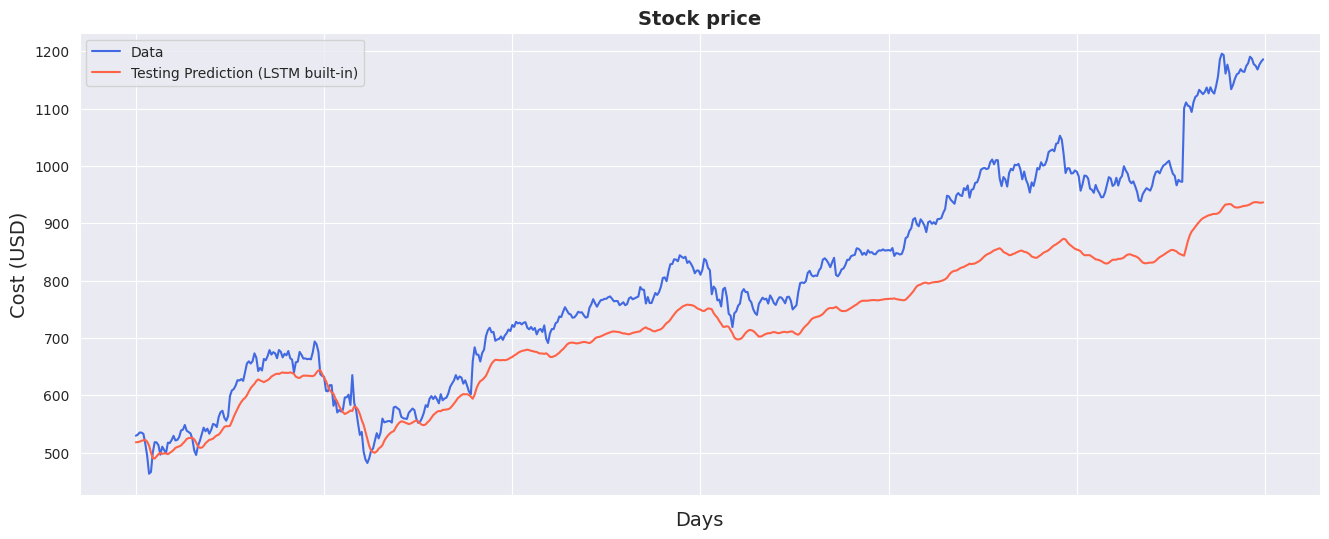

In [ ]:
# Step 4: Plot the prediction results for both training and testing data
# make predictions
with torch.no_grad():
    x_test_LSTM_built_in = x_test_LSTM_built_in.to(device)
    y_test_pred_LSTM_built_in = model(x_test_LSTM_built_in)

predict_test_LSTM_built_in = pd.DataFrame(scaler.inverse_transform(y_test_pred_LSTM_built_in.detach().cpu().numpy()))
original_test_LSTM_built_in = pd.DataFrame(scaler.inverse_transform(y_test_LSTM_built_in.detach().cpu().numpy()))

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test_LSTM_built_in.index, y = original_test_LSTM_built_in[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test_LSTM_built_in.index, y = predict_test_LSTM_built_in[0], label="Testing Prediction (LSTM built-in)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# Step 5: Evaluate the model on testing data and calculate MSE for training and testing sets
# calculate root mean squared error

y_train_LSTM_built_in = y_train_LSTM_built_in.detach().cpu().numpy()
y_train_pred_LSTM_built_in = y_train_pred_LSTM_built_in.detach().cpu().numpy()
trainScore = np.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test_LSTM_built_in = y_test_LSTM_built_in.detach().cpu().numpy()
y_test_pred_LSTM_built_in = y_test_pred_LSTM_built_in.detach().cpu().numpy()
testScore = np.sqrt(mean_squared_error(y_test_LSTM_built_in[:,0], y_test_pred_LSTM_built_in[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.17 RMSE


## 6 - Built-in GRU

Train a 1-layer GRU network using the PyTorch built-in GRU cell.

In [ ]:

# Step 1: Define the GRUNet class
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUNet, self).__init__()

        self.hidden_dim = hidden_dim

        # GRU layer
        self.gru_cell = nn.GRUCell(input_dim, hidden_dim)

        # Linear layer for regression
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        device = x.device
        seq_length = x.size(1)

        # Initialize hidden state
        h_t = torch.zeros(x.size(0), self.hidden_dim).to(device)

        # Use a for-loop to define the forward pass of the GRU network
        for t in range(seq_length):
            h_t = self.gru_cell(x[:, t, :], h_t)

        # Use the output embedding of the last timestep as the input to the linear layer
        output = self.fc(h_t)

        return output

In [ ]:
# Step 2: Create the model, loss function, and optimizer
input_dim = 1  # Input dimension (number of features in the input)
hidden_dim = 32  # Number of units in the hidden GRU layer
output_dim = 1  # Output dimension (number of features in the output)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GRUNet(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Step 3: Train the model and record training losses
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    x_train_GRU_built_in = x_train_GRU_built_in.to(device)
    y_train_GRU_built_in = y_train_GRU_built_in.to(device)

    y_train_pred_GRU_built_in = model(x_train_GRU_built_in)

    loss = criterion(y_train_pred_GRU_built_in, y_train_GRU_built_in)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.9101041555404663
Epoch  1 MSE:  0.8769046068191528
Epoch  2 MSE:  0.8446077704429626
Epoch  3 MSE:  0.8131471872329712
Epoch  4 MSE:  0.78244948387146
Epoch  5 MSE:  0.7524538636207581
Epoch  6 MSE:  0.7231251001358032
Epoch  7 MSE:  0.6944379210472107
Epoch  8 MSE:  0.6663662195205688
Epoch  9 MSE:  0.6388802528381348
Epoch  10 MSE:  0.6119460463523865
Epoch  11 MSE:  0.5855254530906677
Epoch  12 MSE:  0.559578537940979
Epoch  13 MSE:  0.5340655446052551
Epoch  14 MSE:  0.5089484453201294
Epoch  15 MSE:  0.4841916263103485
Epoch  16 MSE:  0.45976197719573975
Epoch  17 MSE:  0.4356294572353363
Epoch  18 MSE:  0.41176745295524597
Epoch  19 MSE:  0.3881535232067108
Epoch  20 MSE:  0.3647705316543579
Epoch  21 MSE:  0.3416074216365814
Epoch  22 MSE:  0.31866011023521423
Epoch  23 MSE:  0.29593244194984436
Epoch  24 MSE:  0.27343690395355225
Epoch  25 MSE:  0.25119608640670776
Epoch  26 MSE:  0.22924384474754333
Epoch  27 MSE:  0.20762692391872406
Epoch  28 MSE:  0.1864071

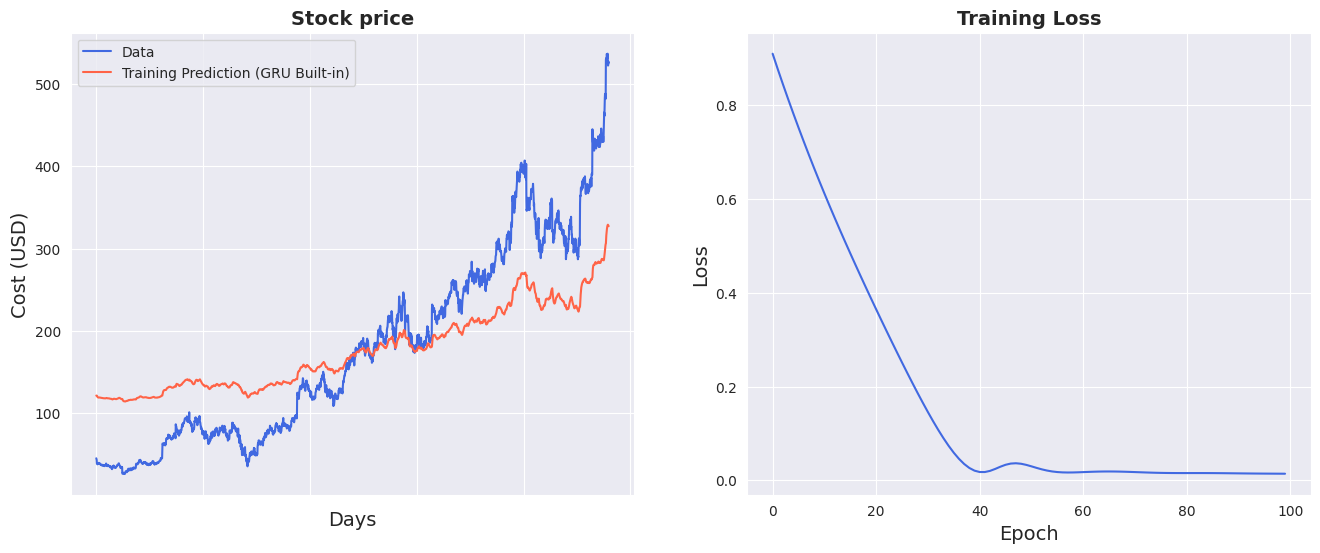

In [ ]:
predict_GRU_built_in = pd.DataFrame(scaler.inverse_transform(y_train_pred_GRU_built_in.detach().cpu().numpy()))
original_GRU_built_in = pd.DataFrame(scaler.inverse_transform(y_train_GRU_built_in.detach().cpu().numpy()))

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original_GRU_built_in.index, y = original_GRU_built_in[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_GRU_built_in.index, y = predict_GRU_built_in[0], label="Training Prediction (GRU Built-in)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

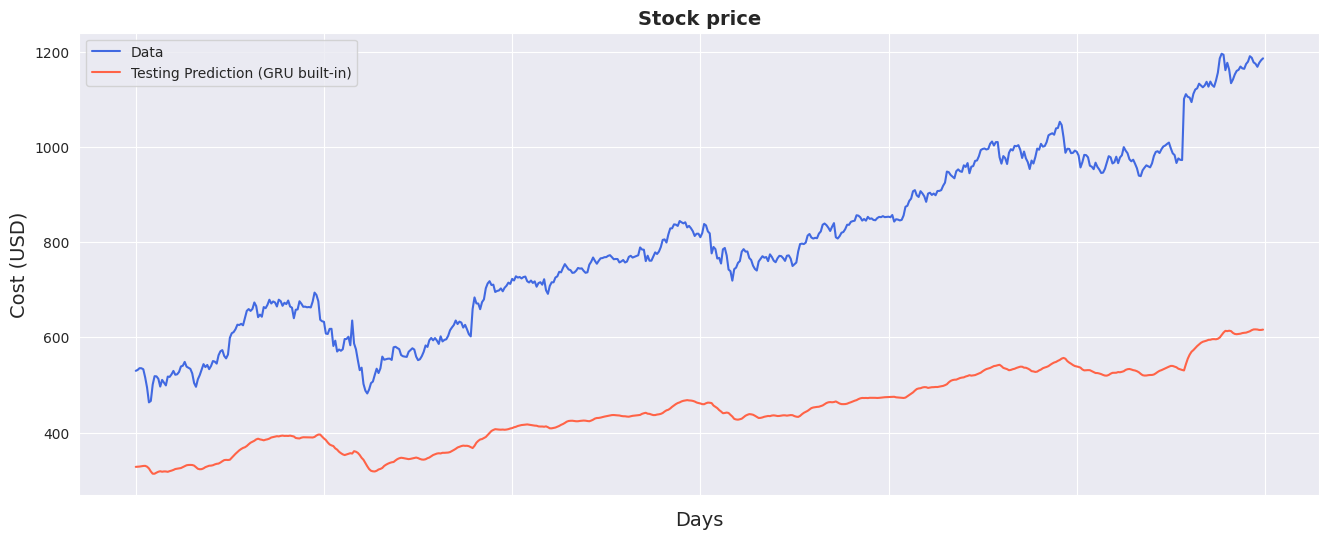

In [ ]:
#Plot the prediction results for both training and testing data
with torch.no_grad():
    x_test_GRU_built_in = x_test_GRU_built_in.to(device)
    y_test_pred_GRU_built_in = model(x_test_GRU_built_in)

predict_test_GRU_built_in = pd.DataFrame(scaler.inverse_transform(y_test_pred_GRU_built_in.detach().cpu().numpy()))
original_test_GRU_built_in = pd.DataFrame(scaler.inverse_transform(y_test_GRU_built_in.detach().cpu().numpy()))

sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 1, 1)
ax = sns.lineplot(x = original_test_GRU_built_in.index, y = original_test_GRU_built_in[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict_test_GRU_built_in.index, y = predict_test_GRU_built_in[0], label="Testing Prediction (GRU built-in)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# calculate root mean squared error
y_train_GRU_built_in = y_train_GRU_built_in.detach().cpu().numpy()
y_train_pred_GRU_built_in = y_train_pred_GRU_built_in.detach().cpu().numpy()
trainScore = np.sqrt(mean_squared_error(y_train_GRU_built_in[:,0], y_train_pred_GRU_built_in[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

y_test_GRU_built_in = y_test_GRU_built_in.detach().cpu().numpy()
y_test_pred_GRU_built_in = y_test_pred_GRU_built_in.detach().cpu().numpy()
testScore = np.sqrt(mean_squared_error(y_test_GRU_built_in[:,0], y_test_pred_GRU_built_in[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.12 RMSE
Test Score: 0.62 RMSE
